Task 1

In [1]:
!pip install -q matplotlib pandas datasets spacy nltk langdetect torch tqdm scipy scikit-learn gensim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import datasets

descriptions_path = "/content/drive/MyDrive/nlp/books.jsonlines"
reviews_path = "/content/drive/MyDrive/nlp/reviews.jsonlines"
stopwords_path = '/content/drive/MyDrive/nlp/stopwords_ua_set.txt'

n_rows = 1000
descriopions = pd.read_json(descriptions_path, lines=True, nrows=n_rows)
dataset = datasets.Dataset.from_pandas(descriopions)
print(descriopions.head(5))

   type                                              title  \
0  book                             Їсти, молитися, кохати   
1  book  Серія книжок про Джуді Муді (комплект із 10 книг)   
2  book                   Три новеллы (комплект из 2 книг)   
3  book  Тренажер мозга. Как развить гибкость мышления ...   
4  book                               У пошуках Івана Сили   

                                        titleEnglish  \
0  Eat, Pray, Love: One Woman's Search for Everyt...   
1                                               None   
2  Och Varje Morgon Blir Vagen. Hem Langre och La...   
3  Brain Coach. Train, Regain and Maintain Your M...   
4                                               None   

                                         description  \
0  «Їсти, молитися, кохати» - надзвичайно щира ро...   
1  На вас чекає знайомство з кумедною дівчинкою н...   
2  Новели Фредріка Бакмана пройняті тим же м'яким...   
3  Ви - це ваш мозок. Ваш мозок має неймовірний п...   
4  Докумен

In [4]:
!python -m spacy download uk_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 25.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('uk_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
import re
import ast
import spacy
import nltk
from langdetect import detect

nltk.download('stopwords')

pipe_ua = spacy.load('uk_core_news_sm')
with open(stopwords_path, 'r') as f:
    sw_ua = ast.literal_eval(f.read())


def preprocess(row, column='description'):
    rewiev = row[column].lower()
    try:
        lang = detect(rewiev)
    except Exception as e:
        lang = None
    if lang == 'uk':
        pipe = pipe_ua
        sw = sw_ua
    else:
        row['all_tokens'] = []
        return row
    cleaned = re.sub(r"[^\w ]", "", rewiev)
    cleaned = re.sub(r" +", " ", cleaned)
    words = [token.lemma_ for token in pipe(cleaned)]
    filtered_words = list(filter(lambda word: word not in sw and len(word) > 0 and word != " ", words))
    row['all_tokens'] = filtered_words
    return row


dataset = dataset.map(preprocess, fn_kwargs={'column': 'description'})

print(len(dataset))
dataset.to_pandas().head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

1000


,type,title,titleEnglish,description,attrs,rating,categories,book_id,all_tokens
0,book,"Їсти, молитися, кохати","Eat, Pray, Love: One Woman's Search for Everyt...","«Їсти, молитися, кохати» - надзвичайно щира ро...","{'ISBN': '978-617-679-153-9, 978-0-670-03471-0...",4.6,"[Книжки, Художня література, Романтична проза,...",0,"[їсти, молитися, кохати, надзвичайно, щирий, р..."
1,book,Серія книжок про Джуді Муді (комплект із 10 книг),None,На вас чекає знайомство з кумедною дівчинкою н...,"{'ISBN': '978-617-679-626-8, 978-617-679-667-1...",5.0,"[Книжки, Дитяча література, Пригоди]",1,"[чекати, знайомство, кумедний, дівчинка, імя, ..."
2,book,Три новеллы (комплект из 2 книг),Och Varje Morgon Blir Vagen. Hem Langre och La...,Новели Фредріка Бакмана пройняті тим же м'яким...,"{'ISBN': '978-5-00131-073-0', 'Ілюстратор': 'О...",5.0,"[Книжки, Художня література, Сучасна проза]",2,"[новела, фредрік, бакмана, пройнятий, мяким, г..."
3,book,Тренажер мозга. Как развить гибкость мышления ...,"Brain Coach. Train, Regain and Maintain Your M...",Ви - це ваш мозок. Ваш мозок має неймовірний п...,"{'ISBN': '978-617-7858-51-4', 'Ілюстратор': No...",NaN,"[Книжки, Саморозвиток. Мотивація, Покращення п...",3,"[мозок, мозок, неймовірний, потенціал, прийти,..."
4,book,У пошуках Івана Сили,None,"Документальні нариси Олександра Гавроша, автор...","{'ISBN': '978-966-10-1967-5, 978-966-10-1539-4...",NaN,"[Книжки, Біографії й мемуари, Спортсмени]",4,"[документальний, нарис, олександр, гаврош, авт..."


In [6]:
from collections import Counter

counts = Counter([i for s in dataset['all_tokens'] for i in s])
counts = {k: v for k, v in counts.items() if v > 3}
vocab = list(counts.keys())
n_v = len(vocab)
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}


def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row


dataset = dataset.map(remove_rare_tokens)

print(n_v)
dataset.to_pandas().head(5)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

3279


,type,title,titleEnglish,description,attrs,rating,categories,book_id,all_tokens,tokens
0,book,"Їсти, молитися, кохати","Eat, Pray, Love: One Woman's Search for Everyt...","«Їсти, молитися, кохати» - надзвичайно щира ро...","{'ISBN': '978-617-679-153-9, 978-0-670-03471-0...",4.6,"[Книжки, Художня література, Романтична проза,...",0,"[їсти, молитися, кохати, надзвичайно, щирий, р...","[їсти, молитися, кохати, надзвичайно, щирий, р..."
1,book,Серія книжок про Джуді Муді (комплект із 10 книг),None,На вас чекає знайомство з кумедною дівчинкою н...,"{'ISBN': '978-617-679-626-8, 978-617-679-667-1...",5.0,"[Книжки, Дитяча література, Пригоди]",1,"[чекати, знайомство, кумедний, дівчинка, імя, ...","[чекати, знайомство, кумедний, дівчинка, імя, ..."
2,book,Три новеллы (комплект из 2 книг),Och Varje Morgon Blir Vagen. Hem Langre och La...,Новели Фредріка Бакмана пройняті тим же м'яким...,"{'ISBN': '978-5-00131-073-0', 'Ілюстратор': 'О...",5.0,"[Книжки, Художня література, Сучасна проза]",2,"[новела, фредрік, бакмана, пройнятий, мяким, г...","[новела, гумор, виданий, сорок, країна, сучасн..."
3,book,Тренажер мозга. Как развить гибкость мышления ...,"Brain Coach. Train, Regain and Maintain Your M...",Ви - це ваш мозок. Ваш мозок має неймовірний п...,"{'ISBN': '978-617-7858-51-4', 'Ілюстратор': No...",NaN,"[Книжки, Саморозвиток. Мотивація, Покращення п...",3,"[мозок, мозок, неймовірний, потенціал, прийти,...","[мозок, мозок, неймовірний, потенціал, прийти,..."
4,book,У пошуках Івана Сили,None,"Документальні нариси Олександра Гавроша, автор...","{'ISBN': '978-966-10-1967-5, 978-966-10-1539-4...",NaN,"[Книжки, Біографії й мемуари, Спортсмени]",4,"[документальний, нарис, олександр, гаврош, авт...","[документальний, нарис, олександр, автор, дитя..."


In [7]:
def sliding_window(row, wsize=4):
    doc = row['tokens']
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i + j for j in
                  range(-wsize, wsize + 1, 1)
                  if (i + j >= 0) &
                  (i + j < len(doc)) &
                  (j != 0)]

        out += [(target, tok2id[doc[w]]) for w in window]
    row['sliding_window'] = out
    return row


wsize = 4

dataset = dataset.filter(lambda x: len(x['tokens']) > 0)
dataset = dataset.map(sliding_window, fn_kwargs={'wsize': wsize})
dataset.to_pandas().head(5)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/690 [00:00<?, ? examples/s]

,type,title,titleEnglish,description,attrs,rating,categories,book_id,all_tokens,tokens,sliding_window
0,book,"Їсти, молитися, кохати","Eat, Pray, Love: One Woman's Search for Everyt...","«Їсти, молитися, кохати» - надзвичайно щира ро...","{'ISBN': '978-617-679-153-9, 978-0-670-03471-0...",4.6,"[Книжки, Художня література, Романтична проза,...",0,"[їсти, молитися, кохати, надзвичайно, щирий, р...","[їсти, молитися, кохати, надзвичайно, щирий, р...","[[0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 2..."
1,book,Серія книжок про Джуді Муді (комплект із 10 книг),None,На вас чекає знайомство з кумедною дівчинкою н...,"{'ISBN': '978-617-679-626-8, 978-617-679-667-1...",5.0,"[Книжки, Дитяча література, Пригоди]",1,"[чекати, знайомство, кумедний, дівчинка, імя, ...","[чекати, знайомство, кумедний, дівчинка, імя, ...","[[67, 68], [67, 69], [67, 70], [67, 71], [68, ..."
2,book,Три новеллы (комплект из 2 книг),Och Varje Morgon Blir Vagen. Hem Langre och La...,Новели Фредріка Бакмана пройняті тим же м'яким...,"{'ISBN': '978-5-00131-073-0', 'Ілюстратор': 'О...",5.0,"[Книжки, Художня література, Сучасна проза]",2,"[новела, фредрік, бакмана, пройнятий, мяким, г...","[новела, гумор, виданий, сорок, країна, сучасн...","[[152, 122], [152, 153], [152, 154], [152, 41]..."
3,book,Тренажер мозга. Как развить гибкость мышления ...,"Brain Coach. Train, Regain and Maintain Your M...",Ви - це ваш мозок. Ваш мозок має неймовірний п...,"{'ISBN': '978-617-7858-51-4', 'Ілюстратор': No...",NaN,"[Книжки, Саморозвиток. Мотивація, Покращення п...",3,"[мозок, мозок, неймовірний, потенціал, прийти,...","[мозок, мозок, неймовірний, потенціал, прийти,...","[[209, 209], [209, 210], [209, 211], [209, 212..."
4,book,У пошуках Івана Сили,None,"Документальні нариси Олександра Гавроша, автор...","{'ISBN': '978-966-10-1967-5, 978-966-10-1539-4...",NaN,"[Книжки, Біографії й мемуари, Спортсмени]",4,"[документальний, нарис, олександр, гаврош, авт...","[документальний, нарис, олександр, автор, дитя...","[[245, 246], [245, 247], [245, 11], [245, 137]..."


In [8]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
    def __init__(self, dataset, vocab_len, n_negs=20):
        self.dataset = dataset
        self.vocab_len = vocab_len
        self.data = [i for s in dataset['sliding_window'] for i in s]
        self.all_tokens = [item for row in self.dataset['tokens'] for item in row]
        self.n_negs = n_negs
        self.neg_samples = np.random.choice(vocab_len, size=(len(self.data), n_negs), p=self.neg_sampling_prob())

    def neg_sampling_prob(self):
        # Use unigram distribution raised to the 3/4rd power
        word_freq = np.array([self.all_tokens.count(word) for word in vocab])
        unigram_dist = word_freq / word_freq.sum() if word_freq.sum() > 0 else np.ones(self.vocab_len) / self.vocab_len
        neg_sampling_dist = unigram_dist ** 0.75
        neg_sampling_dist /= neg_sampling_dist.sum()
        return neg_sampling_dist

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        center, context = self.data[idx]
        neg_samples = self.neg_samples[idx]
        return center, context, neg_samples

BATCH_SIZE = n_v
N_LOADER_PROCS = 8
N_NEGS = 50
dataloader = {}
dataloader['train'] = DataLoader(Word2VecDataset(dataset, vocab_len=n_v, n_negs=N_NEGS), batch_size=BATCH_SIZE, shuffle=True, num_workers=N_LOADER_PROCS)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
d = Word2VecDataset(dataset, vocab_len=n_v, n_negs=N_NEGS)
for center, context, neg_samples in d:
  print(center, context, neg_samples)
  print(id2tok[center], id2tok[context], [id2tok[x] for x in neg_samples])
  break

0 1 [ 920 1422  806 1847 1542 1061   15 1057 1541  909  241 1580 2200  926
 2030 2269 1997 3038 1278  630  466  555  561  274 3059   13 1553 3249
  666  323   71 2537  942 2425   12  526   53 1637 1055 1166 1942 3270
 1115 3095  540 2030 1954 2840  839 1563]
їсти молитися ['забезпечити', 'архетип', 'бурхливий', 'apple', 'селище', 'казати', 'довести', 'кіно', 'minecraft', 'їжа', 'застосувати', 'ситуація', 'кулінарний', 'вийти', 'побувати', 'генетичний', 'консультант', 'лифар', 'мріяти', 'гарний', 'сотня', 'найширший', 'робота', 'авторський', 'радикальний', 'власний', 'відвідувати', 'хореографічний', 'яскравий', 'колега', 'імя', 'однойменний', 'українська', 'косметичний', 'книга', 'секрет', 'творчість', 'реальність', 'область', 'розпізнати', 'надавати', 'маглы', 'розповісти', 'футбол', 'бізнес', 'побувати', 'xxi', 'виробляти', 'телевізійний', 'місакі']


In [10]:
import torch
from torch import nn

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_size)

    def forward(self, center, context, neg_samples):
        center_embeds = self.embeddings(center)
        context_embeds = self.context_embeddings(context)
        neg_embeds = self.context_embeddings(neg_samples)

        pos_score = torch.mul(center_embeds, context_embeds).squeeze()
        pos_score = torch.sum(pos_score, dim=1)
        pos_score = torch.log(torch.sigmoid(pos_score))

        neg_score = torch.bmm(neg_embeds, center_embeds.unsqueeze(2)).squeeze()
        neg_score = torch.sum(torch.log(torch.sigmoid(-neg_score)), dim=1)

        return -torch.mean(pos_score + neg_score)


In [11]:
from tqdm import tqdm

EMBED_SIZE = 200
LR = 5e-4
EPOCHS = 200

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Word2Vec(n_v, EMBED_SIZE)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

running_loss = []
for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0
    for center, context, neg_samples in dataloader['train']:
        center, context, neg_samples = center.to(device), context.to(device), neg_samples.to(device)
        optimizer.zero_grad()
        loss = model(center, context, neg_samples)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 200/200 [15:22<00:00,  4.61s/it]


In [12]:
word2vec = model.context_embeddings.weight.cpu().detach().numpy()

In [13]:
tokens = ['кумедний', 'жінка', 'авторка', 'молитися', 'їсти', 'гра']

In [14]:
from scipy.spatial import distance
import numpy as np


def get_similar(word, dist_matrix, k=1):
    if word not in tok2id:
        return []
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k + 1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out


dmatrix = distance.squareform(distance.pdist(word2vec, 'cosine'))
for word in tokens:
    print(word, [t[1] for t in get_similar(word, dmatrix, k=3)], "\n")

кумедний ['сімї', 'дитинство', 'муракамі'] 

жінка ['чоловік', 'правило', 'здатність'] 

авторка ['відомий', 'принести', 'путівник'] 

молитися ['кохати', 'вязання', 'відкритий'] 

їсти ['мадам', 'орієнтований', 'прочитаєте'] 

гра ['пяти', 'додаватися', 'чарівний'] 



In [15]:
i = 0
for vec in word2vec:
    if [np.isnan(x) for x in word2vec[0]].count(True) == EMBED_SIZE:
      i += 1
print(i, len(word2vec))

0 3279


In [16]:
from collections import Counter

all_tokens = [item for row in dataset['tokens'] for item in row]

word_counts = Counter(all_tokens)

common_words = [word for word, _ in word_counts.most_common(50)]

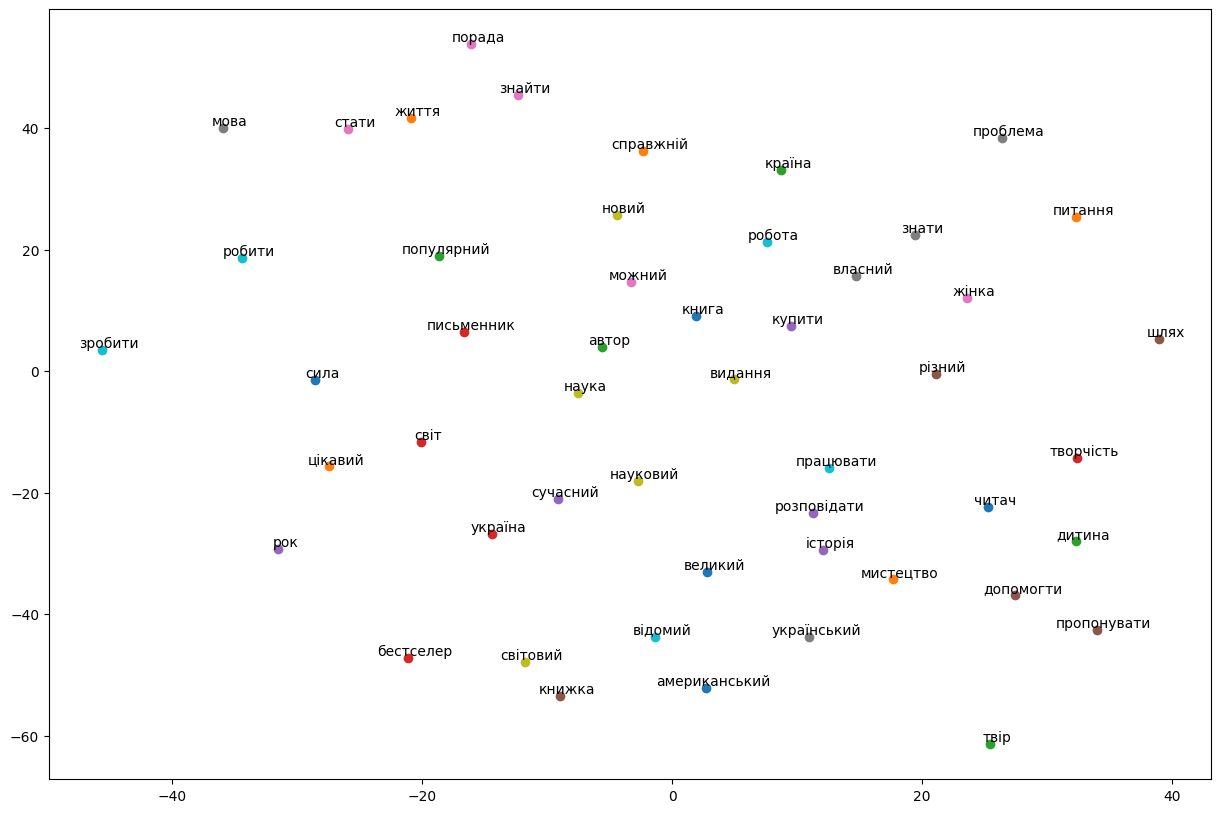

In [17]:
from sklearn.manifold import TSNE


def visualize_embeddings(word_vectors, word_index, figsize=(50, 40)):
    # Since we have a very small number of samples, we set perplexity to a low value
    # Perplexity should be less than the number of samples
    tsne = TSNE(n_components=2, random_state=0, perplexity=5)  # Adjust perplexity here
    vectors_2d = tsne.fit_transform(word_vectors)

    # Plotting the results
    plt.figure(figsize=figsize)
    for word, index in word_index.items():
        x, y = vectors_2d[index]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), textcoords="offset points", xytext=(5, 2), ha='center')

    plt.show()

word_vectors = []
word_index = {}
for i, word in enumerate(common_words):
    word_vectors.append(word2vec[tok2id[word]])
    word_index[word] = i
word_vectors = np.array(word_vectors)

visualize_embeddings(word_vectors, word_index, figsize=(15, 10))

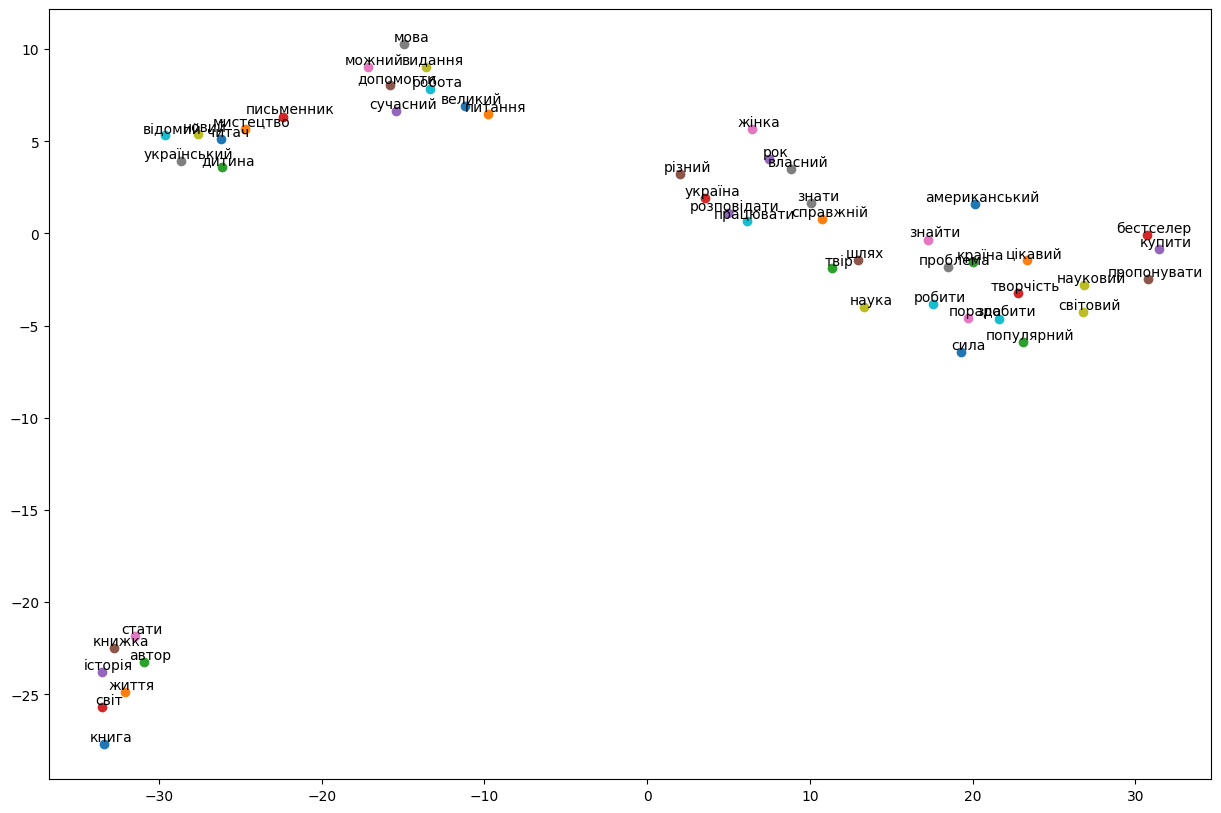

In [18]:
import gensim
from gensim.models import Word2Vec

sentences = dataset['all_tokens']

model_gensim = Word2Vec(sentences, vector_size=EMBED_SIZE, window=wsize, min_count=1, workers=4)

word_vectors = []
word_index = {}
for i, word in enumerate(common_words):
    word_vectors.append(model_gensim.wv[word])
    word_index[word] = i

word_vectors = np.array(word_vectors)
visualize_embeddings(word_vectors, word_index, figsize=(15, 10))



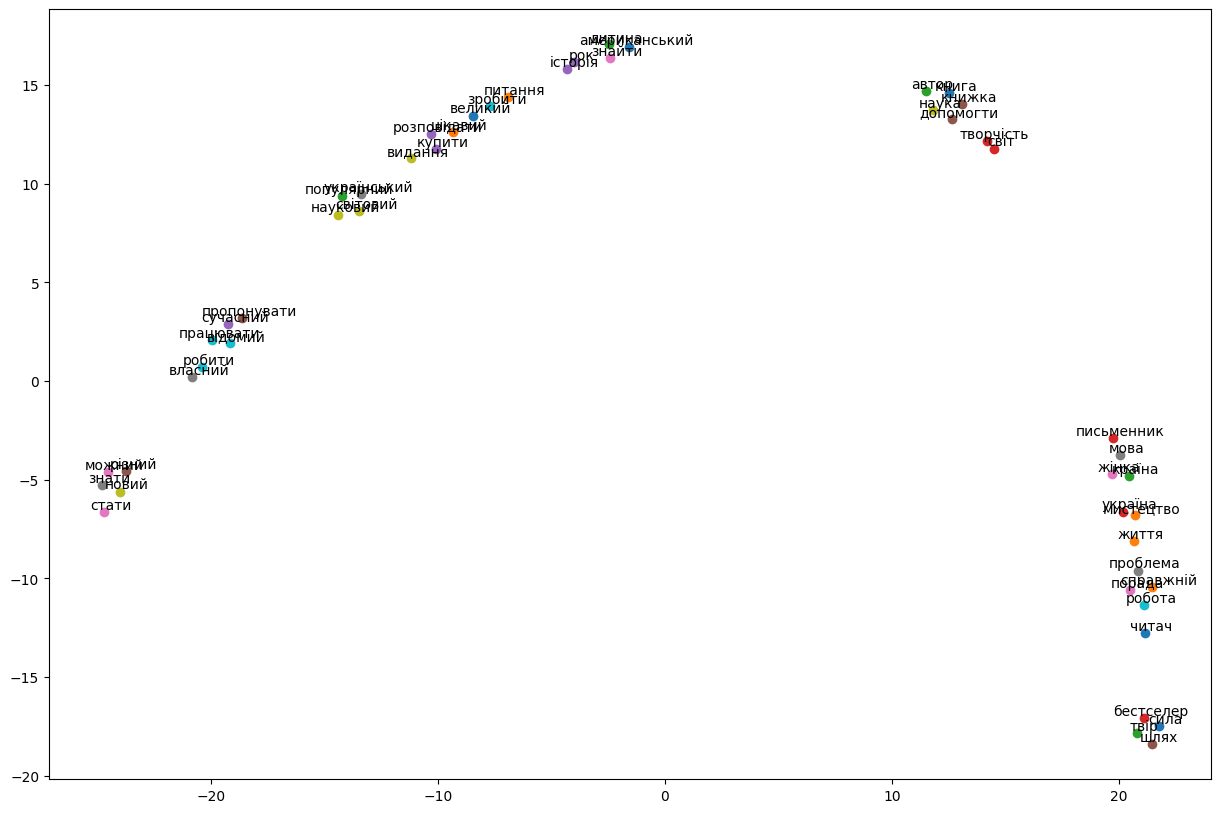

In [19]:
from gensim.models import FastText

fasttext_model = FastText(sentences, vector_size=EMBED_SIZE, window=3, min_count=1, workers=4)

word_vectors = []
word_index = {}
for i, word in enumerate(common_words):
    word_vectors.append(fasttext_model.wv[word])
    word_index[word] = i

word_vectors = np.array(word_vectors)
visualize_embeddings(word_vectors, word_index, figsize=(15, 10))